# Neural Networks using Spectograms

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow
import os
import cv2
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from skimage.transform import resize
from keras.applications.resnet50 import preprocess_input

## Save spectrograms arrays to file in order to speed up loading data

In [ ]:
mel_spectogram_data = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/mel_spectrograms'
mfcc_spectogram_data = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/mfcc_spectrograms'
standard_spectogram_data = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/standard_spectrograms'

In [ ]:
def load_spectograms(spectogram_data):
  X, y, classes = [], [], []

  for label, genre in enumerate(os.listdir(spectogram_data)):
      classes.append(genre)
      genre_path = os.path.join(spectogram_data, genre)

      if os.path.isdir(genre_path):
          for img_file in os.listdir(genre_path):
              img_path = os.path.join(genre_path, img_file)

              if os.path.isfile(img_path):
                  img = load_img(img_path, color_mode='grayscale')
                  img_array = img_to_array(img)
                  X.append(img_array)
                  y.append(genre)

  X = np.array(X)
  y = np.array(y)

  print(X.shape, y.shape, classes)

  return X, y, classes

In [ ]:
mfcc_X, mfcc_y, mfcc_classes = load_spectograms(mfcc_spectogram_data)
mel_X, mel_y, mel_classes = load_spectograms(mel_spectogram_data)
standard_X, standard_y, standard_classes = load_spectograms(standard_spectogram_data)

np.save('X.npy', mfcc_X)
np.save('y.npy', mfcc_y)
np.save('classes.npy', mfcc_classes)

np.save('X.npy', mel_X)
np.save('y.npy', mel_y)
np.save('classes.npy', mel_classes)

np.save('X.npy', standard_X)
np.save('y.npy', standard_y)
np.save('classes.npy', standard_classes)

(999, 308, 465, 1) (999,) ['reggae', 'blues', 'metal', 'country', 'rock', 'hiphop', 'classical', 'jazz', 'disco', 'pop']
(996, 308, 465, 1) (996,) ['reggae', 'blues', 'metal', 'country', 'rock', 'hiphop', 'classical', 'jazz', 'disco', 'pop']
(999, 308, 465, 1) (999,) ['reggae', 'blues', 'metal', 'country', 'rock', 'hiphop', 'classical', 'jazz', 'disco', 'pop']


## Load spectogram images

In [ ]:
spectogram_dir = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/mel_spectrograms'

X = np.load(os.path.join(spectogram_dir, 'X.npy'))
y = np.load(os.path.join(spectogram_dir, 'y.npy'))
classes = np.load(os.path.join(spectogram_dir, 'classes.npy'))

print(X.shape, y.shape, classes)

(996, 308, 465, 1) (996,) ['reggae' 'blues' 'metal' 'country' 'rock' 'hiphop' 'classical' 'jazz'
 'disco' 'pop']


# Build Neural Network models

## NN Model 1

In [ ]:
def create_nn_model_1():
  model = Sequential(name='Model_1')
  model.add(Conv2D(64, 2, activation = 'relu', input_shape = X.shape[1:]))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.1))
  model.add(Conv2D(128, 2, activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.1))
  model.add(Conv2D(256, 2, activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (4,4)))
  model.add(Dropout(0.1))
  model.add(Conv2D(512, 2, activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (8,8)))
  model.add(Dropout(0.1))

  model.add(Flatten())

  model.add(Dense(2048, activation = 'relu'))
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dense(128, activation = 'relu'))

  model.add(Dense(10, activation = 'softmax'))
  # model.summary()

  return model

## NN Model 2

In [ ]:
def create_nn_model_2():
  model = Sequential(name='Model_2')
  model.add(Conv2D(64, 2, activation = 'relu', input_shape = X.shape[1:]))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(32, 2, activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(32, 2, activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Flatten())

  model.add(Dense(64, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(32, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(16, activation = 'relu'))
  model.add(BatchNormalization())

  model.add(Dense(10, activation = 'softmax'))
  # model.summary()

  return model

## NN Model 3

In [ ]:
def create_nn_model_3():
  model = Sequential(name='Model_3')
  model.add(Conv2D(64, (3, 3), input_shape = X.shape[1:], padding="same", activation='relu'))
  model.add(Conv2D(64, (3, 3), strides=(4, 4), padding="same", activation='relu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(128, (3, 3), strides=(4, 4), padding='same', activation='relu'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(1024, activation=LeakyReLU(alpha=0.1)))
  model.add(BatchNormalization())

  model.add(Dense(512, activation=LeakyReLU(alpha=0.1)))
  model.add(BatchNormalization())

  model.add(Dense(256, activation=LeakyReLU(alpha=0.1)))
  model.add(BatchNormalization())

  model.add(Dense(10, activation = 'softmax'))
  # model.summary()

  return model

## ResNet50

In [ ]:
def resnet_resize_X(X):
  X_resized = np.array([resize(img, (224, 224, 3)) for img in X])

  if X_resized.shape[-1] == 1:
    X_resized = np.concatenate([X_resized]*3, axis=-1)

  preprocessed_X = preprocess_input(X_resized)

  return preprocessed_X

In [ ]:
def create_nn_model_4():
  resnet = ResNet50(weights='imagenet', include_top=False, classes=10, input_shape=X.shape[1:])
  print("ResNet50 layers:",len(resnet.layers))

  for layer in resnet.layers:
    layer.trainable = False

  model = Sequential(name='Model_ResNet50')
  model.add(resnet)
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(216, activation='relu'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))

  return model

# Encode labels & split the data

## Encode labels

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)
print(y_onehot.shape)

(996, 10)


## Split data into test & train sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_test.shape)

(796, 308, 465, 1) (200, 308, 465, 1) (200, 10)


# Create subdirectories for checkpoints & compile model

In [ ]:
model = create_nn_model_1()

In [ ]:
checkpoint_dir = "/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/"
checkpoint_subdir = os.path.join(checkpoint_dir, model._name)
if not os.path.exists(checkpoint_subdir):
  os.makedirs(checkpoint_subdir)

checkpoint_path = os.path.join(checkpoint_subdir, "best_model.h5")

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Train model

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64, callbacks=[checkpoint])
loss, accuracy = model.evaluate(X_test, y_test)

print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 15.9860 - accuracy: 0.1093
Epoch 1: val_accuracy improved from -inf to 0.13000, saving model to /content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_1/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 31s 1s/step - loss: 15.9860 - accuracy: 0.1093 - val_loss: 2.2960 - val_accuracy: 0.1300
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 2.2736 - accuracy: 0.1018
Epoch 2: val_accuracy improved from 0.13000 to 0.18000, saving model to /content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_1/best_model.h5
13/13 [==============================] - 15s 1s/step - loss: 2.2736 - accuracy: 0.1018 - val_loss: 2.2444 - val_accuracy: 0.1800
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 2.1142 - accuracy: 0.2085
Epoch 3: val_accuracy improved from 0.18000 to 0.30000, saving model to /content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_1/best_model.h5
13/13 [==============================] - 14s 1s/step - loss: 2.1142 - accuracy: 0.2085 - val_loss: 2.0044 - val_accuracy: 0.3000
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 1.9167 - accuracy: 0.2952
Epoch 4: val_accuracy di

# Calculate model metrics

In [ ]:
checkpoint_dir = "/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/"
models_y = {}

for dictionary in os.listdir(checkpoint_dir):
  if dictionary == "Model_ResNet50":
    X = resnet_resize_X(X)

  X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, shuffle=True)
  best_model_path = os.path.join(checkpoint_dir, dictionary)
  best_model = tensorflow.keras.models.load_model(best_model_path + "/best_model.h5")

  predict_results = best_model.predict(X_test)

  y_pred = np.argmax(predict_results, axis=1)
  y_test = np.argmax(y_test, axis=1)

  y_dict = {'y_pred': y_pred, 'y_test': y_test}
  models_y[str(dictionary)] = y_dict

7/7 [==============================] - 0s 36ms/step
(996, 224, 224, 3)
7/7 [==============================] - 2s 95ms/step


In [ ]:
for model in models_y:
  y_pred = models_y.get(model).get('y_pred')
  y_test = models_y.get(model).get('y_test')
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred, target_names=classes)
  print(str(model) + " statistics")
  print(report)
  print(f'Accuracy: {accuracy:.4f}' + '\n')

Model_1 statistics
              precision    recall  f1-score   support

      reggae       0.67      0.71      0.69        14
       blues       0.94      1.00      0.97        17
       metal       0.83      0.43      0.57        23
     country       0.69      0.74      0.71        27
        rock       0.67      0.96      0.79        23
      hiphop       0.71      0.83      0.77        12
   classical       0.92      0.85      0.88        26
        jazz       0.88      0.78      0.82        18
       disco       1.00      0.43      0.60        21
         pop       0.63      1.00      0.78        19

    accuracy                           0.77       200
   macro avg       0.79      0.77      0.76       200
weighted avg       0.80      0.77      0.75       200

Accuracy: 0.7650

Model_2 statistics
              precision    recall  f1-score   support

      reggae       0.12      0.07      0.09        14
       blues       0.31      1.00      0.47        17
       metal       0.2

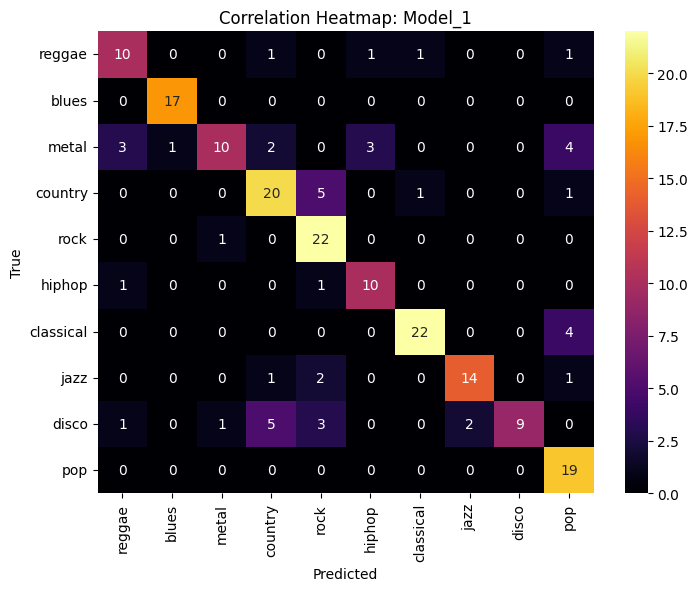

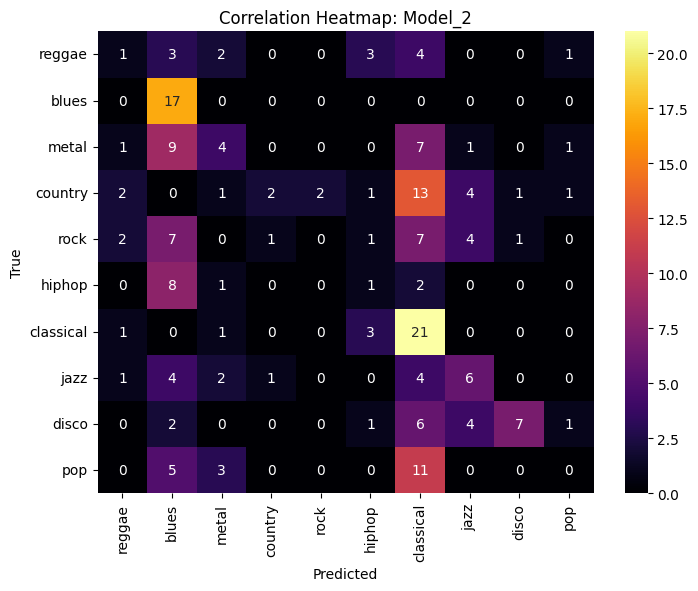

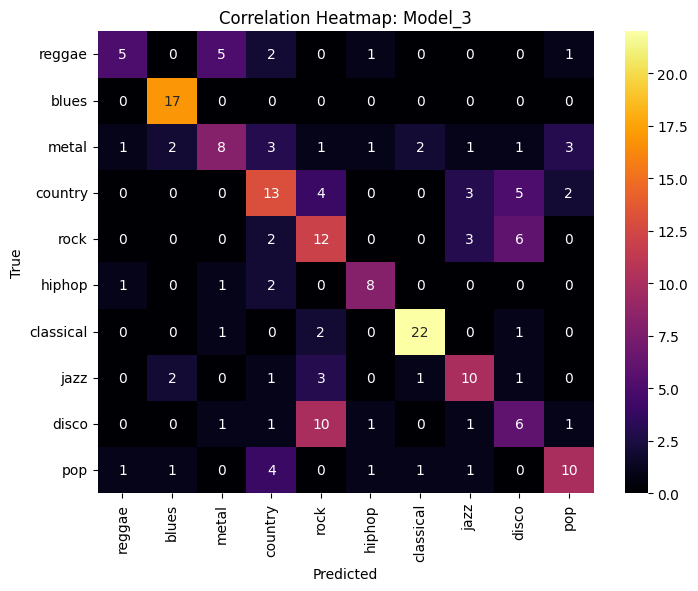

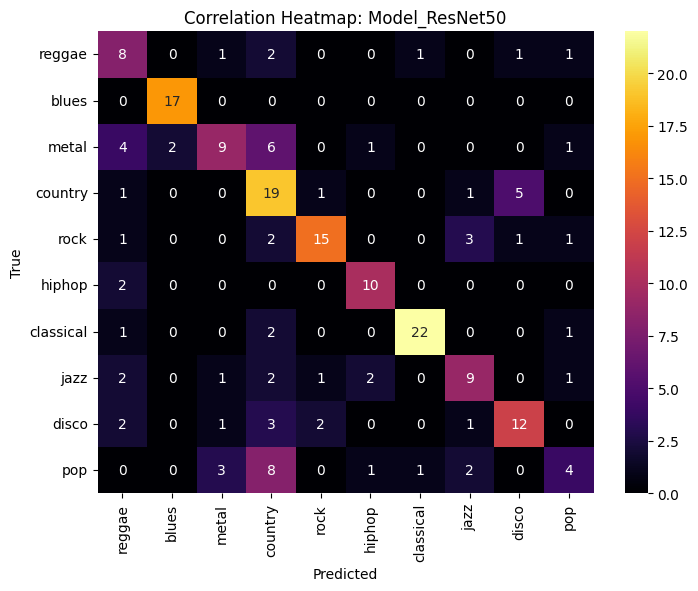

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for model in models_y:
  y_pred = models_y.get(model).get('y_pred')
  y_test = models_y.get(model).get('y_test')
  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=classes, yticklabels=classes)
  plt.title('Correlation Heatmap: ' + str(model))
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()